--- Ver.0.4 ---

Ver.0.3での問題点の改善
Networkxの最適化が不全（Nodeを指定する動作と、Edgeの指定を分ける。Edgeには全てのデータを投入可能）
縦軸にfor_subjectのリンク数、横軸にfor_objectのリンク数を位置取るタイプのGraphを作る
条件をいじれるような気候の開発（ボタン？）
長い文章を表示できるような機構の開発（ボタン？）
path_listに応じたarrowの色変更
summarizeは表示するNodeを指定するだけ
search => choice_node => draw の三段階

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Searching for :  地球温暖化
Searching for the 1st depth of the graph : 地球温暖

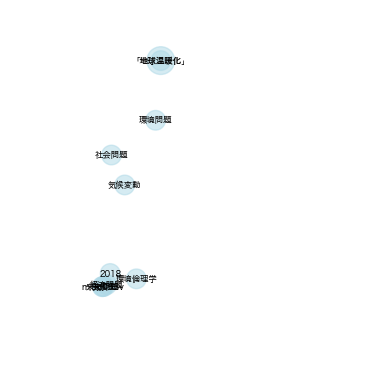

順位,名前,スコア(優先順位付け),オブジェクト(参照リンク)の数,サブジェクト(参照元リンク)の数
1 : 地球温暖化 3.0 316 1223
2 : 2018 3 42 71
3 : 気候変動 2.1 121 550
4 : 環境問題 2.1 288 900
5 : 社会問題 2.1 49 712
6 : 気候史 1.1 8 1
7 : 経済問題 1.1 24 11
8 : 環境倫理学 1.1 184 42
9 : 未来問題 1.1 0 0
10 : m.0d063v 1 0 0


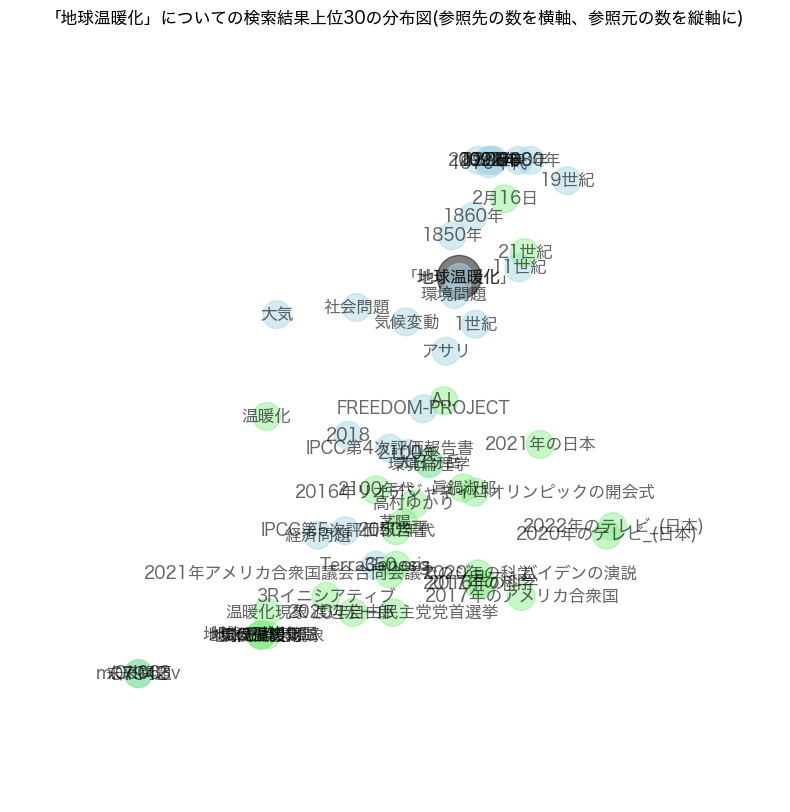

順位,名前,スコア(優先順位付け),オブジェクト(参照リンク)の数のLOG,サブジェクト(参照元リンク)の数のLOG
for object（ライトブルー）
1 : 地球温暖化 3.0 2.5010592622177517 3.087781417809542
2 : 2018 3 1.6334684555795864 1.8573324964312685
3 : 気候変動 2.1 2.0863598306747484 2.741151598851785
4 : 環境問題 2.1 2.4608978427565478 2.954724790979063
5 : 社会問題 2.1 1.6989700043360187 2.8530895298518657
6 : 気候史 1.1 0.9542425094393249 0.3010299956639812
7 : 経済問題 1.1 1.3979400086720377 1.0791812460476249
8 : 環境倫理学 1.1 2.2671717284030137 1.6334684555795864
9 : 未来問題 1.1 0.0 0.0
10 : m.0d063v 1 0.0 0.0
11 : 2021年 1 2.7299742856995555 4.000043427276863
12 : 2100年 1 2.0969100130080562 1.7160033436347992
13 : FREEDOM-PROJECT 1 2.220108088040055 2.0644579892269186
14 : IPCC第4次評価報告書 1 1.9590413923210936 1.7558748556724915
15 : IPCC第5次評価報告書 1 1.6127838567197355 1.1139433523068367
16 : 大気 1 1.0791812460476249 2.7972675408307164
17 : 11世紀 1 2.9661417327390325 3.162862993321926
18 : 1850年 1 2.444044795918076 3.4122925093230463
19 : 1860年 1 2.60959440922522 3.5618166643189575


In [86]:
%pip install SPARQLWrapper
%pip install networkx
%pip install japanize-matplotlib
# !pip install matplotlib
from SPARQLWrapper import SPARQLWrapper
sparql = SPARQLWrapper(endpoint='http://ja.dbpedia.org/sparql', returnFormat='json')
input_name = input("Enter the name you want to search: ")
print("Searching for : ", input_name)
import networkx as nx 
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.family'] = 'Hiragino Sans'



def get_results_for_subject(input):
    query_sentence_for_subject = "SELECT * where { ?s ?p <" + input + "> . }"
    sparql.setQuery(query_sentence_for_subject)
    results_for_subject = sparql.query().convert()
    if "results" in results_for_subject.keys() and "bindings" in results_for_subject["results"].keys():
        return results_for_subject["results"]["bindings"]
    else:
        return []

def get_results_for_object(input):
    query_sentence_for_object = "SELECT * where { <" + input + "> ?p ?o . }"
    sparql.setQuery(query_sentence_for_object)
    results_for_object = sparql.query().convert()
    if "results" in results_for_object.keys() and "bindings" in results_for_object["results"].keys():
        return results_for_object["results"]["bindings"]
    else:
        return []
    
def scored_result(results,type="o"):
    scored_result = []
    weight_list = [{"weight" : 0.9 , "p" : "http://www.w3.org/1999/02/22-rdf-syntax-ns#type" }, 
               {"weight" : 1 , "p" : "http://dbpedia.org/ontology/wikiPageWikiLink"} , 
               {"weight" : -0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
               {"weight" : -1 , "p" : "http://dbpedia.org/ontology/wikiPageRevisionID"},
               {"weight" : -0.1 , "p" : "http://dbpedia.org/ontology/commonName"},
               {"weight" : -0.1 , "p" : "http://dbpedia.org/ontology/postalCode"},
               {"weight" : -0.1 , "p" : "http://dbpedia.org/ontology/wikiPageExternalLink"},
               {"weight" : -0.1 , "p" : "http://ja.dbpedia.org/property/外部リンク"},
               {"weight" : -1 , "p" : 'http://dbpedia.org/ontology/wikiPageID'},
               {"weight" : -0.1 , "p" : "http://www.w3.org/2000/01/rdf-schema#label"},
               {"weight" : -0.1 , "p" : "http://www.w3.org/2004/02/skos/core#prefLabel"},
               {"weight" : 0.1 , "p" : "http://purl.org/dc/terms/subject"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            #    {"weight" : 0.1 , "p" : "http://xmlns.com/foaf/0.1/name"},
            ]
    for result in results:
        new_item = {}
        new_item["name"] = result[type]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")
        new_item["score"] = 1
        if len(new_item["name"]) < 3 or len(new_item["name"]) > 10:
            new_item["score"] = -0.1
        for weight in weight_list:
            if weight["p"] in result["p"]["value"]:
                new_item["score"] = weight["weight"]
                print("weight : " + str(weight["weight"]) + " p : " + weight["p"])
                break
        if new_item["name"] in [item["name"] for item in scored_result]:
            for item in scored_result:
                if item["name"] == new_item["name"]:
                    item["score"] += new_item["score"]
                    break
        else:
            scored_result.append(new_item)
        scored_result.sort(key=lambda x: x["score"], reverse=True)
    return scored_result

        
    




print("Searching for the 1st depth of the graph : " + input_name)
results_for_subject = get_results_for_subject("http://ja.dbpedia.org/resource/" + input_name)
results_for_object = get_results_for_object("http://ja.dbpedia.org/resource/" + input_name)
print(results_for_subject)

print("## Choose Nodename ##")
node_name_depth_1_for_subject = []
node_name_depth_1_for_object = []
if results_for_object != []:
    path_list = []
    path_list += results_for_object
    path_list += results_for_subject
    if len(results_for_object) < 10:
        node_name_depth_1_for_object = [str(result["o"]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")) for result in results_for_object]
        print(node_name_depth_1_for_object)
    else:
        print("Too many objects. Now we are going to choose the top 10 objects.")
        node_name_depth_1_for_object = scored_result(results_for_object)
        # print([item["name"] for item in node_name_depth_1_for_object])
        # print([item["score"] for item in node_name_depth_1_for_object])
    results_for_o2_of_o1 = {}
    results_for_s2_of_o1 = {}
    for i in range(min(len(node_name_depth_1_for_object), 30)):
        results_for_o2_of_o1[node_name_depth_1_for_object[i]["name"]] = get_results_for_object("http://ja.dbpedia.org/resource/" + str(node_name_depth_1_for_object[i]["name"]))
        results_for_s2_of_o1[node_name_depth_1_for_object[i]["name"]] = get_results_for_subject("http://ja.dbpedia.org/resource/" + str(node_name_depth_1_for_object[i]["name"]))
        print(node_name_depth_1_for_object[i]["name"],node_name_depth_1_for_object[i]["score"],len(results_for_o2_of_o1),len(results_for_s2_of_o1))

if results_for_subject != []:
    if len(results_for_subject) < 10:
        node_name_depth_1_for_subject = [str(result["s"]["value"].split("/")[-1].replace("Category:", "").replace("Template:", "")) for result in results_for_subject]
        print(node_name_depth_1_for_subject)
    else:
        print("Too many subjects. Now we are going to choose the top 10 subjects.")
        node_name_depth_1_for_subject = scored_result(results_for_subject, type="s")
        # print([item["name"] for item in node_name_depth_1_for_subject])
        # print([item["score"] for item in node_name_depth_1_for_subject])
    results_for_o2_of_s1 = {}
    results_for_s2_of_s1 = {}
    for i in range(min(len(node_name_depth_1_for_subject), 30)):
        print(node_name_depth_1_for_subject[i])
        results_for_o2_of_s1[node_name_depth_1_for_subject[i]["name"]] = get_results_for_object("http://ja.dbpedia.org/resource/" + str(node_name_depth_1_for_subject[i]["name"]))
        results_for_s2_of_s1[node_name_depth_1_for_subject[i]["name"]] = get_results_for_subject("http://ja.dbpedia.org/resource/" + str(node_name_depth_1_for_subject[i]["name"]))
        print(node_name_depth_1_for_subject[i]["name"],node_name_depth_1_for_subject[i]["score"],len(results_for_o2_of_s1),len(results_for_s2_of_s1))

G = nx.DiGraph()
pos={}
node_size = [400]
G.add_node("「" + input_name + "」")
pos["「" + input_name + "」"] = (len(results_for_object),len(results_for_subject))
# print(len(node_name_depth_1_for_object))
# print(len(node_name_depth_1_for_subject))
if node_name_depth_1_for_object != []:
    for i in range(min(len(node_name_depth_1_for_object), 10)):
        G.add_node(node_name_depth_1_for_object[i]["name"])
        pos[node_name_depth_1_for_object[i]["name"]] = (len(results_for_o2_of_o1[node_name_depth_1_for_object[i]["name"]]),len(results_for_s2_of_o1[node_name_depth_1_for_object[i]["name"]]))
        G.add_edge("「" + input_name + "」", node_name_depth_1_for_object[i]["name"])
        node_size.append(200)
        
# for name in node_name_depth_1_for_object:
#     print(name)
#     if results_for_object_depth_2_of_o != []:
#         G.add_node(name)
#         pos[name] = (len(node_name_depth_1_for_object),len(node_name_depth_1_for_subject))
#         G.add_edge("「" + input_name + "」", name)
#         node_size.append(500)
    
fig = plt.figure(facecolor="w")
ax = fig.add_subplot(111)
ax.set_xlim(-500, 1500)
ax.set_ylim(-500, 1500)
ax.set_aspect('equal')
ax.set_axis_off()
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=node_size, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=6, font_family="Hiragino Sans")
plt.show()

print("順位,名前,スコア(優先順位付け),オブジェクト(参照リンク)の数,サブジェクト(参照元リンク)の数")
for i in range(min(len(node_name_depth_1_for_object), 10)):
    print(i+1,":",node_name_depth_1_for_object[i]["name"],node_name_depth_1_for_object[i]["score"],len(results_for_o2_of_o1[node_name_depth_1_for_object[i]["name"]]),len(results_for_s2_of_o1[node_name_depth_1_for_object[i]["name"]]))

G = nx.DiGraph()
pos={}
node_size = {"「" + input_name + "」": 1000}
node_color = {"「" + input_name + "」": "black"}
G.add_node("「" + input_name + "」")
pos["「" + input_name + "」"] = (math.log10(1+len(results_for_object)),math.log10(1+len(results_for_subject)))
# print(len(node_name_depth_1_for_object))
# print(len(node_name_depth_1_for_subject))
if node_name_depth_1_for_object != []:
    for i in range(min(len(node_name_depth_1_for_object), 30)):
        G.add_node(node_name_depth_1_for_object[i]["name"])
        pos[node_name_depth_1_for_object[i]["name"]] = (math.log10(1+len(results_for_o2_of_o1[node_name_depth_1_for_object[i]["name"]])),math.log10(1+len(results_for_s2_of_o1[node_name_depth_1_for_object[i]["name"]])))
        G.add_edge("「" + input_name + "」", node_name_depth_1_for_object[i]["name"])
        node_size[node_name_depth_1_for_object[i]["name"]] = 400
        node_color[node_name_depth_1_for_object[i]["name"]] = "lightblue"
if node_name_depth_1_for_subject != []:
    for i in range(min(len(node_name_depth_1_for_subject), 30)):
        G.add_node(node_name_depth_1_for_subject[i]["name"])
        pos[node_name_depth_1_for_subject[i]["name"]] = (math.log10(1+len(results_for_o2_of_s1[node_name_depth_1_for_subject[i]["name"]])),math.log10(1+len(results_for_s2_of_s1[node_name_depth_1_for_subject[i]["name"]])))
        G.add_edge("「" + input_name + "」", node_name_depth_1_for_subject[i]["name"])
        node_size[node_name_depth_1_for_subject[i]["name"]] = 400
        node_color[node_name_depth_1_for_subject[i]["name"]] = "lightgreen"

fig = plt.figure(figsize=(10, 10), facecolor="w",linewidth=5)
ax = fig.add_subplot(111)
ax.set_xlim(-1, 5)
ax.set_ylim(-1, 5)
ax.set_aspect('equal')
ax.set_axis_off()
nx.draw_networkx_nodes(G, pos, alpha=0.5, node_size=[v for v in node_size.values()], node_color=[v for v in node_color.values()])
nx.draw_networkx_labels(G, pos, font_size=12, font_family="Hiragino Sans",alpha=0.6)
plt.title("「" + input_name + "」についての検索結果上位30の分布図(参照先の数を横軸、参照元の数を縦軸に)", fontsize=12)
plt.show()

print("順位,名前,スコア(優先順位付け),オブジェクト(参照リンク)の数のLOG,サブジェクト(参照元リンク)の数のLOG")
print("for object（ライトブルー）")
for i in range(min(len(node_name_depth_1_for_object), 30)):
    print(i+1,":",node_name_depth_1_for_object[i]["name"],node_name_depth_1_for_object[i]["score"],math.log10(1+len(results_for_o2_of_o1[node_name_depth_1_for_object[i]["name"]])),math.log10(1+len(results_for_s2_of_o1[node_name_depth_1_for_object[i]["name"]])))
print("for subject（ライトグリーン）")
for i in range(min(len(node_name_depth_1_for_subject), 30)):
    print(i+1,":",node_name_depth_1_for_subject[i]["name"],node_name_depth_1_for_subject[i]["score"],math.log10(1+len(results_for_o2_of_s1[node_name_depth_1_for_subject[i]["name"]])),math.log10(1+len(results_for_s2_of_s1[node_name_depth_1_for_subject[i]["name"]])))












